In [1]:
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
#import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import numpy as np

from __future__ import division
import os
import shutil
from subprocess import call
import itertools
import fnmatch
from calendar import monthrange
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import geopandas as gpd
import pandas as pd

In [2]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

### lvl 1 setups

import sys
sys.path.append('/portal1/dell/GitHub/WAYS')
sys.path.append('/portal1/dell/GitHub/sanctuary')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import hstack
from matplotlib import pyplot
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')

In [3]:
from numpy import polyfit, poly1d
from stats import cr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [4]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from stats import cr
from gistool import basemap, stack_image, stack_shp, stack_hatch, stack_shp_cn, ncslice
from spatial import upscale
import statsmodels.formula.api as smf
from scipy.stats.mstats import theilslopes
from scipy.stats import kendalltau
import cartopy.crs as ccrs

import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt

import climate_indices as indices
from climate_indices import compute
from climate_indices import utils, indices

In [5]:
import geopandas as gpd
from shapely import wkt

In [ ]:
for k in range(1960,1964):
    df = pd.read_csv('fd_wet_traj/traj_pro/'+str(k)+'_pro.csv')
    
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    lonn = gdf.geometry.x.values
    latt = gdf.geometry.y.values
    sph = gdf['Specific_Humidity'].values
    traj_loc_sp = np.stack((gdf.geometry.x.values, gdf.geometry.y.values, gdf['Specific_Humidity'].values), axis=-1)
    last_traj_number = df['traj'].iloc[-1][4:]


    domain_n = np.zeros((361,721))
    domain_m = np.zeros((361,721))
    lat_largescale= list(np.linspace(90,-90,361))
    lon_largescale= list(np.linspace(-180,180,721))
    pscf_domain_n= xr.DataArray(domain_n, coords=[lat_largescale, lon_largescale], dims=['lat','lon']) 
    pscf_domain_m= xr.DataArray(domain_m, coords=[lat_largescale, lon_largescale], dims=['lat','lon'])
    
    from datetime import datetime
    print(str(k)+"begin:", datetime.now())
    
    last_traj_number = df['traj'].iloc[-1][4:]   # how much traj you have   int(last_traj_number)
    for i in range(int(last_traj_number)):
        
        traj_indexes = df[df['traj'] == 'traj'+str(i)].index
        for j in range(traj_indexes[0], traj_indexes[-1]):  # how much traj point in specific traj
            
            pscf_loc_n=pscf_domain_n.sel(lat=traj_loc_sp[j][1],lon=traj_loc_sp[j][0],method='nearest')
            lat_pscf_n=lat_largescale.index(pscf_loc_n.lat.values)
            lon_pscf_n=lon_largescale.index(pscf_loc_n.lon.values)
            domain_n[lat_pscf_n][lon_pscf_n]=domain_n[lat_pscf_n][lon_pscf_n]+1
            
            
            # calculate how much the traj point in specific grid of (last_traj -> path_traj) 
            if traj_loc_sp[j][2] > traj_loc_sp[traj_indexes[0]][2]:
                pscf_loc_m=pscf_domain_m.sel(lat=traj_loc_sp[j][1],lon=traj_loc_sp[j][0],method='nearest')
                lat_pscf_m=lat_largescale.index(pscf_loc_m.lat.values)
                lon_pscf_m=lon_largescale.index(pscf_loc_m.lon.values)
                domain_m[lat_pscf_m][lon_pscf_m]=domain_m[lat_pscf_m][lon_pscf_m]+1
        if i%5000 == 0:
            print(str(k)+"__"+str(i), datetime.now())
    
    print(str(k)+"end:", datetime.now())
    
    pscf_sustech = domain_m/domain_n
    ds_pscf_sustech = xr.DataArray(pscf_sustech, coords=[lat_largescale,lon_largescale], dims=['lat','lon']) 
    ds_pscf_sustech.to_netcdf('pscf_wet/pscf_'+str(k)+'.nc')
    condition_1 = domain_n > 80
    condition_2 = (20 < domain_n) & (domain_n <= 80)
    condition_3 = (10 < domain_n) & (domain_n <= 20)
    condition_4 = domain_n <= 10
    
    pscf_sustech[condition_1] *= 1.0
    pscf_sustech[condition_2] *= 0.7
    pscf_sustech[condition_3] *= 0.42
    pscf_sustech[condition_4] *= 0.05
    ds_wpscf_sustech = xr.DataArray(pscf_sustech, coords=[lat_largescale,lon_largescale], dims=['lat','lon']) 
    ds_wpscf_sustech.to_netcdf('pscf_wet/wpscf_'+str(k)+'.nc')

1960begin: 2023-12-01 18:55:40.085046
1960__0 2023-12-01 18:55:40.720966


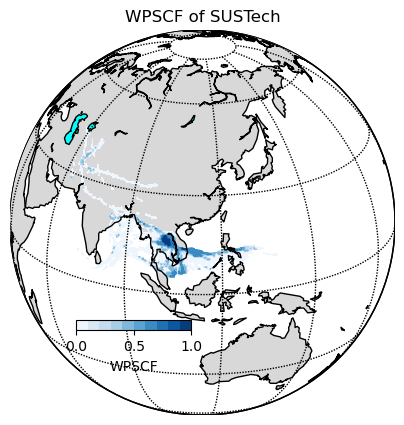

In [17]:
# Generate some sample data for demonstration
lons, lats = np.meshgrid(wpscf_sustech.lon.values, wpscf_sustech.lat.values)

data = wpscf_sustech.values
# Plotting contourf
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

map = Basemap(projection='ortho', lat_0=22, lon_0=114, resolution='c', ax=ax)
map.drawcoastlines(linewidth=1)
map.fillcontinents(color='#d8d8d8', lake_color='aqua')
map.drawmapboundary(fill_color='#FFFFFF')
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))
plt.title('WPSCF of SUSTech')

# Contour plot
contour_plot = map.contourf(lons, lats, data, cmap='Blues',latlon=True,levels=np.linspace(0,1,11))

# Add colorbar
cax = fig.add_axes([0.26, 0.28, 0.23, 0.02])
cbar = plt.colorbar(contour_plot, cax=cax, orientation='horizontal', extend='max')
cbar.set_label('WPSCF')
cbar.set_ticks([0,0.5,1.0])


# Show the plot
plt.show()